In [1]:
import GPy
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
import os
os.chdir('/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML/sample code/')

In [3]:
# load training data
absorb = scio.loadmat('absorbance_TX_hitemp.mat')['absorb']
paraMat = scio.loadmat('para_TX_hitemp.mat')
Temper = paraMat['Temper']
Temper=np.reshape(Temper,-1)[:,None]
Conc_1 = paraMat['Conc_1']
Conc_1=np.reshape(Conc_1,-1)[:,None]
Conc_2 = paraMat['Conc_2']
Conc_2=np.reshape(Conc_2,-1)[:,None]

In [4]:
absorb.shape

(1000, 998)

In [5]:
Temper.shape

(1000, 1)

In [6]:
X = np.arange(0, 1000)

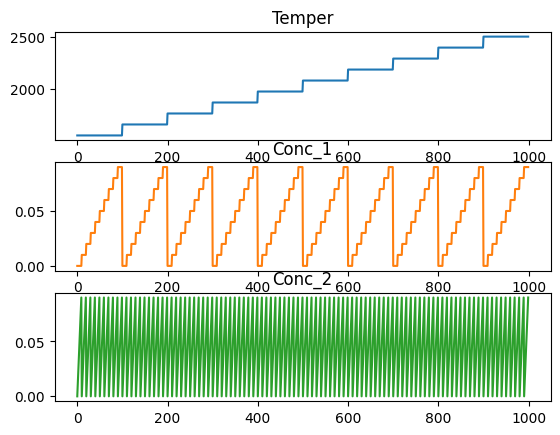

In [7]:
figure, axis = plt.subplots(3, 1) 

axis[0].plot(X, Temper)
axis[0].set_title('Temper')
axis[1].plot(X, Conc_1, 'tab:orange')
axis[1].set_title('Conc_1')
axis[2].plot(X, Conc_2, 'tab:green')
axis[2].set_title('Conc_2')
plt.show()

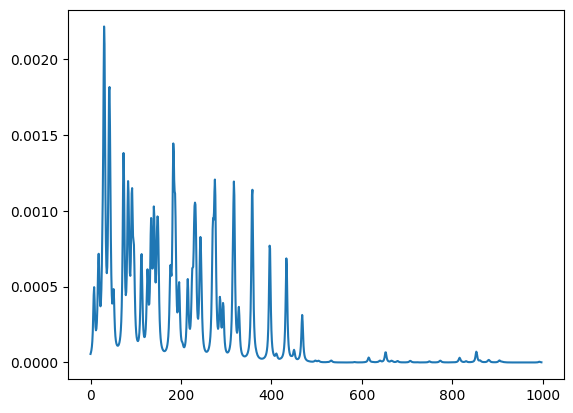

In [8]:
import matplotlib.pyplot as plt

plt.plot(absorb[1])

In [9]:
# normalization
scalerT = StandardScaler().fit(Temper)
scalerX_1 = StandardScaler().fit(Conc_1)
scalerX_2 = StandardScaler().fit(Conc_2)
Temper=scalerT.transform(Temper)
Conc_1=scalerX_1.transform(Conc_1)
Conc_2=scalerX_2.transform(Conc_2)

In [10]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(absorb)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(absorb)[1],num_outputs=3,kernel=ks)

In [11]:
print(icm)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (3, 1)  |               |        
  B.kappa          |    (3,)  |      +ve      |        
W matrix
   index  |      ICM.B.W  |  constraints  |  priors
  [0 0]  |   0.44862577  |               |        
  [1 0]  |  -0.39152844  |               |        
  [2 0]  |   0.44475695  |               |        

kappa vector
   index  |  ICM.B.kappa  |  constraints  |  priors
  [0]    |   0.50000000  |      +ve      |        
  [1]    |   0.50000000  |      +ve      |        
  [2]    |   0.50000000  |      +ve      |        

B matrix
 [[ 0.70126508 -0.17564975  0.19952943]
 [-0.17564975  0.65329452 -0.17413499]
 [ 0.19952943 -0.17413499  0.69780874]]


In [12]:
m = GPy.models.GPCoregionalizedRegression([absorb,absorb,absorb],[Temper,Conc_1,Conc_2],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 3713.5396138676724
Number of Parameters : 11
Number of Optimization Parameters : 10
Updates : True
Parameters:
  gp.                                    |   value  |  constraints  |  priors
  ICM.rbf.variance                       |     1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |     1.0  |      +ve      |        
  ICM.B.W                                |  (3, 1)  |               |        
  ICM.B.kappa                            |    (3,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_2.variance  |     1.0  |      +ve      |        


In [13]:
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)

W matrix
   index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |   0.44862577  |               |        
  [1 0]  |  -0.39152844  |               |        
  [2 0]  |   0.44475695  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        
  [2]    |      0.50000000  |      +ve      |        


In [14]:
m.optimize()

In [15]:
print(m)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)


Name : gp
Objective : -10875.495484413941
Number of Parameters : 11
Number of Optimization Parameters : 10
Updates : True
Parameters:
  gp.                                    |                   value  |  constraints  |  priors
  ICM.rbf.variance                       |                     1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |     0.17130890892234357  |      +ve      |        
  ICM.B.W                                |                  (3, 1)  |               |        
  ICM.B.kappa                            |                    (3,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |     0.01853408116670856  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |  5.562684646268137e-309  |      +ve      |        
  mixed_noise.Gaussian_noise_2.variance  |  5.562684646268137e-309  |      +ve      |        
W matrix
   index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  149.02451385  |               |        
 

In [16]:
# load test data and normalization
absorb_test = scio.loadmat('absorbance_TXtest_hitemp_noise.mat')['absorb']
paraMat_test = scio.loadmat('para_TXtest_hitemp.mat')
Temper_test = paraMat_test['Temper']
Temper_test=np.reshape(Temper_test,-1)[:,None]
Conc_1_test = paraMat_test['Conc_1']
Conc_1_test=np.reshape(Conc_1_test,-1)[:,None]
Conc_2_test = paraMat_test['Conc_2']
Conc_2_test=np.reshape(Conc_2_test,-1)[:,None]

In [17]:
absorb_test.shape

(50, 998)

In [18]:
Temper_test.shape

(50, 1)

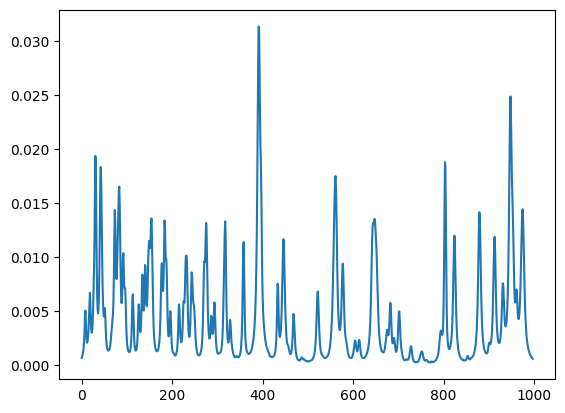

In [19]:
plt.plot(absorb_test[1])

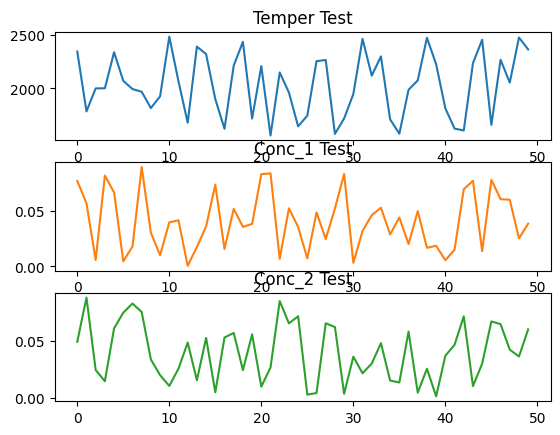

In [20]:
figure, axis = plt.subplots(3, 1) 

axis[0].plot(Temper_test)
axis[0].set_title('Temper Test')
axis[1].plot(Conc_1_test, 'tab:orange')
axis[1].set_title('Conc_1 Test')
axis[2].plot(Conc_2_test, 'tab:green')
axis[2].set_title('Conc_2 Test')
plt.show()

In [30]:
# prediction of T
newX = absorb_test
newX = np.concatenate((newX,np.zeros((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Temper_test_=scalerT.inverse_transform(ys)

AxisError: axis 1 is out of bounds for array of dimension 1

In [22]:
# prediction of X1
newX = absorb_test
newX = np.concatenate((newX,np.ones((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Conc_1_test_=scalerX_1.inverse_transform(ys)

In [23]:
# prediction of X2
newX = absorb_test
newX = np.concatenate((newX,2*np.ones((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Conc_2_test_=scalerX_2.inverse_transform(ys)

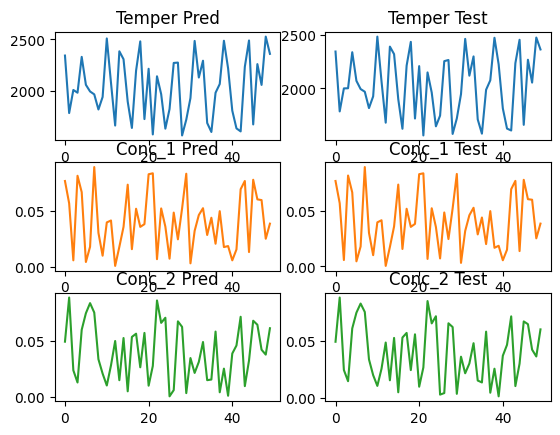

In [24]:
figure, axis = plt.subplots(3, 2) 

axis[0][0].plot(Temper_test_)
axis[0][0].set_title('Temper Pred')
axis[1][0].plot(Conc_1_test_, 'tab:orange')
axis[1][0].set_title('Conc_1 Pred')
axis[2][0].plot(Conc_2_test_, 'tab:green')
axis[2][0].set_title('Conc_2 Pred')
axis[0][1].plot(Temper_test)
axis[0][1].set_title('Temper Test')
axis[1][1].plot(Conc_1_test, 'tab:orange')
axis[1][1].set_title('Conc_1 Test')
axis[2][1].plot(Conc_2_test, 'tab:green')
axis[2][1].set_title('Conc_2 Test')
plt.show()

In [25]:
from sklearn import metrics

In [26]:
conc_1 = metrics.mean_squared_log_error(np.array(Conc_1_test), np.array(Conc_1_test_))
conc_1

5.833868471312032e-08

In [27]:
conc_2 = metrics.mean_squared_log_error(np.array(Conc_2_test), np.array(Conc_2_test))
conc_2

0.0

In [28]:
temp = metrics.mean_squared_log_error(Temper_test_, Temper_test)
temp

9.356568071513312e-05

In [29]:
print(f'The mean squared log error for the Test and Predicted class is as follows, Temp: {temp}, Concentration 1: {conc_1} and Concentration 2: {conc_2}')

The mean squared log error for the Test and Predicted class is as follows, Temp: 9.356568071513312e-05, Concentration 1: 5.833868471312032e-08 and Concentration 2: 0.0
